In [233]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

import joblib

import shap
import catboost
import xgboost as xgb
import lightgbm as lgb

from tqdm import tqdm_notebook
import scipy.optimize as spo
from category_encoders import BinaryEncoder

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold

In [234]:
def run_lgbm(X_train, X_test, y_train, y_test, feature_names, categorical_features='auto', model_params=None, fit_params=None, seed=21):

    X_train_GBM = lgb.Dataset(X_train, label=y_train, feature_name=feature_names, categorical_feature=categorical_features, free_raw_data=False)
    X_test_GBM = lgb.Dataset(X_test, label=y_test, reference=X_train_GBM, feature_name=feature_names, free_raw_data=False)
    
    if model_params is None:
        model_params = {'seed': seed, 'num_threads': 16, 'objective':'root_mean_squared_error', 
                        'metric': ['root_mean_squared_error'] }
    
    if fit_params is None:
        fit_params = {'verbose_eval': True, 'num_boost_round': 3000, 'valid_sets': [X_test_GBM], 
                      'early_stopping_rounds': 30,'categorical_feature': categorical_features, 'feature_name': feature_names}
        
    model = lgb.train(model_params, X_train_GBM, **fit_params)
    y_pred = model.predict(X_test, model.best_iteration)
    return model, y_pred, mean_squared_error(y_test, y_pred)

## Lgbm

In [235]:
df_train_dataset = pd.read_pickle('data/df/df_train_dataset.pkl')
df_validation_dataset = pd.read_pickle('data/df/df_validation_dataset.pkl')

In [236]:
continuous_features = joblib.load('data/iterables/continuous_features.joblib')
categorical_features = joblib.load('data/iterables/categorical_features.joblib')
target_features = joblib.load('data/iterables/target_features.joblib')
target_transformer = joblib.load('models/preprocessing/target_transformer.joblib')

ft_shape_drop = joblib.load('data/iterables/ft_shape_drop.joblib')

In [237]:
df_train_dataset.shape, df_validation_dataset.shape

((338192, 84), (146765, 84))

In [238]:
# continuous_features = [c for c in continuous_features if c not in ft_shape_drop]
# categorical_features = [c for c in categorical_features if c not in ft_shape_drop]

In [239]:
X = df_train_dataset[categorical_features + continuous_features].values
y = df_train_dataset[target_features].values.flatten()
print(X.shape, y.shape)

(338192, 77) (338192,)


In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, test_size=0.15, shuffle=True, random_state=10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(287463, 77) (50729, 77) (287463,) (50729,)


In [241]:
param_ints = ['max_depth', 'bagging_freq', 'num_leaves', 'min_data_in_leaf', 'min_data_per_group', 'max_bin', 
              'min_data_in_bin', 'max_cat_threshold']
best_parameters = joblib.load('models/parameters/best_parameters.joblib')

model_params = {'num_threads': 16, 'objective': 'root_mean_squared_error', 
                'metric': ['root_mean_squared_error'], 'boosting': 'gbdt'}
for param, value_ in best_parameters.items():
    if param == 'boost_from_average':
        continue
        
    if param in param_ints:
        model_params[param] = int(value_)
    else:
        model_params[param] = value_

In [242]:
NUM_REGRESSORS = 5

In [243]:
regressors = []

i = 0
seeds = [320, 357,  78,  88, 507]
rkf = KFold(n_splits=5, shuffle=True, random_state=21)
for train_index, test_index in tqdm_notebook(rkf.split(X_train, y_train)):
    XTr, XTe = X_train[train_index], X_train[test_index]
    ytr, yte = y_train[train_index], y_train[test_index]
    print(XTr.shape, XTe.shape, ytr.shape, yte.shape)
    
    feature_names = categorical_features + continuous_features
    reg_lgbm, y_pred, score = run_lgbm(XTr, XTe, ytr, yte, feature_names, categorical_features, model_params=model_params, seed=seeds[i])
    regressors.append(reg_lgbm)
    i += 1

(229970, 77) (57493, 77) (229970,) (57493,)


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'cat_are_all_travelling', 'cat_booking_date_day', 'cat_booking_date_is_weekend', 'cat_booking_date_month', 'cat_booking_date_week', 'cat_booking_date_weekday', 'cat_booking_date_year', 'cat_cf_is_cluster_changed', 'cat_cf_is_resort_changed', 'cat_cf_is_resort_region_changed', 'cat_cf_is_resort_type_changed', 'cat_cf_is_room_type_booked_changed', 'cat_cf_is_season_holidayed_changed', 'cat_cf_is_state_resort_changed', 'cat_checkin_date_day', 'cat_checkin_date_is_weekend', 'cat_checkin_date_month', 'cat_checkin_date_week', 'cat_checkin_date_weekday', 'cat_checkin_date_year', 'cat_checkout_date_day', 'cat_checkout_date_is_weekend', 'cat_checkout_date_month', 'cat_checkout_date_week', 'cat_checkout_date_weekday', 'cat_checkout_date_year', 'channel_code', 'cluster_code', 'main_product_code', 'member_age_bucket

[1]	valid_0's rmse: 0.137207
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's rmse: 0.136792
[3]	valid_0's rmse: 0.136391
[4]	valid_0's rmse: 0.135976
[5]	valid_0's rmse: 0.135683
[6]	valid_0's rmse: 0.135433
[7]	valid_0's rmse: 0.135173
[8]	valid_0's rmse: 0.134907
[9]	valid_0's rmse: 0.134614
[10]	valid_0's rmse: 0.13433
[11]	valid_0's rmse: 0.134026
[12]	valid_0's rmse: 0.133771
[13]	valid_0's rmse: 0.133511
[14]	valid_0's rmse: 0.133365
[15]	valid_0's rmse: 0.133075
[16]	valid_0's rmse: 0.132874
[17]	valid_0's rmse: 0.132666
[18]	valid_0's rmse: 0.132467
[19]	valid_0's rmse: 0.13223
[20]	valid_0's rmse: 0.132119
[21]	valid_0's rmse: 0.13195
[22]	valid_0's rmse: 0.131758
[23]	valid_0's rmse: 0.131563
[24]	valid_0's rmse: 0.131323
[25]	valid_0's rmse: 0.13115
[26]	valid_0's rmse: 0.130999
[27]	valid_0's rmse: 0.130829
[28]	valid_0's rmse: 0.130708
[29]	valid_0's rmse: 0.130523
[30]	valid_0's rmse: 0.130369
[31]	valid_0's rmse: 0.130291
[32]	valid_0's rmse: 

[272]	valid_0's rmse: 0.125672
[273]	valid_0's rmse: 0.12567
[274]	valid_0's rmse: 0.125668
[275]	valid_0's rmse: 0.125667
[276]	valid_0's rmse: 0.125665
[277]	valid_0's rmse: 0.125664
[278]	valid_0's rmse: 0.125661
[279]	valid_0's rmse: 0.125659
[280]	valid_0's rmse: 0.125656
[281]	valid_0's rmse: 0.125654
[282]	valid_0's rmse: 0.125653
[283]	valid_0's rmse: 0.125653
[284]	valid_0's rmse: 0.125651
[285]	valid_0's rmse: 0.12565
[286]	valid_0's rmse: 0.125648
[287]	valid_0's rmse: 0.125645
[288]	valid_0's rmse: 0.125642
[289]	valid_0's rmse: 0.125639
[290]	valid_0's rmse: 0.125639
[291]	valid_0's rmse: 0.125638
[292]	valid_0's rmse: 0.125637
[293]	valid_0's rmse: 0.125636
[294]	valid_0's rmse: 0.125635
[295]	valid_0's rmse: 0.125632
[296]	valid_0's rmse: 0.125632
[297]	valid_0's rmse: 0.125632
[298]	valid_0's rmse: 0.125631
[299]	valid_0's rmse: 0.12563
[300]	valid_0's rmse: 0.12563
[301]	valid_0's rmse: 0.125629
[302]	valid_0's rmse: 0.125628
[303]	valid_0's rmse: 0.125627
[304]	valid_

[542]	valid_0's rmse: 0.12549
[543]	valid_0's rmse: 0.125491
[544]	valid_0's rmse: 0.12549
[545]	valid_0's rmse: 0.125489
[546]	valid_0's rmse: 0.125487
[547]	valid_0's rmse: 0.125487
[548]	valid_0's rmse: 0.125486
[549]	valid_0's rmse: 0.125486
[550]	valid_0's rmse: 0.125486
[551]	valid_0's rmse: 0.125485
[552]	valid_0's rmse: 0.125486
[553]	valid_0's rmse: 0.125484
[554]	valid_0's rmse: 0.125485
[555]	valid_0's rmse: 0.125484
[556]	valid_0's rmse: 0.125483
[557]	valid_0's rmse: 0.125483
[558]	valid_0's rmse: 0.125483
[559]	valid_0's rmse: 0.125483
[560]	valid_0's rmse: 0.125483
[561]	valid_0's rmse: 0.125483
[562]	valid_0's rmse: 0.125484
[563]	valid_0's rmse: 0.125484
[564]	valid_0's rmse: 0.125484
[565]	valid_0's rmse: 0.125484
[566]	valid_0's rmse: 0.125482
[567]	valid_0's rmse: 0.125482
[568]	valid_0's rmse: 0.125482
[569]	valid_0's rmse: 0.125481
[570]	valid_0's rmse: 0.125481
[571]	valid_0's rmse: 0.12548
[572]	valid_0's rmse: 0.12548
[573]	valid_0's rmse: 0.12548
[574]	valid_0

[812]	valid_0's rmse: 0.125437
[813]	valid_0's rmse: 0.125436
[814]	valid_0's rmse: 0.125437
[815]	valid_0's rmse: 0.125437
[816]	valid_0's rmse: 0.125436
[817]	valid_0's rmse: 0.125436
[818]	valid_0's rmse: 0.125436
[819]	valid_0's rmse: 0.125436
[820]	valid_0's rmse: 0.125436
[821]	valid_0's rmse: 0.125436
[822]	valid_0's rmse: 0.125436
[823]	valid_0's rmse: 0.125436
[824]	valid_0's rmse: 0.125436
[825]	valid_0's rmse: 0.125436
[826]	valid_0's rmse: 0.125436
[827]	valid_0's rmse: 0.125436
[828]	valid_0's rmse: 0.125436
[829]	valid_0's rmse: 0.125435
[830]	valid_0's rmse: 0.125436
[831]	valid_0's rmse: 0.125436
[832]	valid_0's rmse: 0.125436
[833]	valid_0's rmse: 0.125436
[834]	valid_0's rmse: 0.125436
[835]	valid_0's rmse: 0.125436
[836]	valid_0's rmse: 0.125436
[837]	valid_0's rmse: 0.125435
[838]	valid_0's rmse: 0.125435
[839]	valid_0's rmse: 0.125435
[840]	valid_0's rmse: 0.125435
[841]	valid_0's rmse: 0.125436
[842]	valid_0's rmse: 0.125436
[843]	valid_0's rmse: 0.125436
[844]	va

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'cat_are_all_travelling', 'cat_booking_date_day', 'cat_booking_date_is_weekend', 'cat_booking_date_month', 'cat_booking_date_week', 'cat_booking_date_weekday', 'cat_booking_date_year', 'cat_cf_is_cluster_changed', 'cat_cf_is_resort_changed', 'cat_cf_is_resort_region_changed', 'cat_cf_is_resort_type_changed', 'cat_cf_is_room_type_booked_changed', 'cat_cf_is_season_holidayed_changed', 'cat_cf_is_state_resort_changed', 'cat_checkin_date_day', 'cat_checkin_date_is_weekend', 'cat_checkin_date_month', 'cat_checkin_date_week', 'cat_checkin_date_weekday', 'cat_checkin_date_year', 'cat_checkout_date_day', 'cat_checkout_date_is_weekend', 'cat_checkout_date_month', 'cat_checkout_date_week', 'cat_checkout_date_weekday', 'cat_checkout_date_year', 'channel_code', 'cluster_code', 'main_product_code', 'member_age_bucket

[1]	valid_0's rmse: 0.135244
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's rmse: 0.134829
[3]	valid_0's rmse: 0.134426
[4]	valid_0's rmse: 0.134008
[5]	valid_0's rmse: 0.133714
[6]	valid_0's rmse: 0.133459
[7]	valid_0's rmse: 0.1332
[8]	valid_0's rmse: 0.132933
[9]	valid_0's rmse: 0.132642
[10]	valid_0's rmse: 0.132354
[11]	valid_0's rmse: 0.132041
[12]	valid_0's rmse: 0.131785
[13]	valid_0's rmse: 0.131528
[14]	valid_0's rmse: 0.131384
[15]	valid_0's rmse: 0.131093
[16]	valid_0's rmse: 0.130897
[17]	valid_0's rmse: 0.130694
[18]	valid_0's rmse: 0.130491
[19]	valid_0's rmse: 0.130253
[20]	valid_0's rmse: 0.130134
[21]	valid_0's rmse: 0.129964
[22]	valid_0's rmse: 0.129775
[23]	valid_0's rmse: 0.129577
[24]	valid_0's rmse: 0.129332
[25]	valid_0's rmse: 0.129163
[26]	valid_0's rmse: 0.129015
[27]	valid_0's rmse: 0.128844
[28]	valid_0's rmse: 0.128723
[29]	valid_0's rmse: 0.128538
[30]	valid_0's rmse: 0.128389
[31]	valid_0's rmse: 0.12831
[32]	valid_0's rmse:

[270]	valid_0's rmse: 0.123683
[271]	valid_0's rmse: 0.123681
[272]	valid_0's rmse: 0.12368
[273]	valid_0's rmse: 0.123678
[274]	valid_0's rmse: 0.123677
[275]	valid_0's rmse: 0.123675
[276]	valid_0's rmse: 0.123673
[277]	valid_0's rmse: 0.123672
[278]	valid_0's rmse: 0.123668
[279]	valid_0's rmse: 0.123668
[280]	valid_0's rmse: 0.123664
[281]	valid_0's rmse: 0.123664
[282]	valid_0's rmse: 0.123661
[283]	valid_0's rmse: 0.123661
[284]	valid_0's rmse: 0.123659
[285]	valid_0's rmse: 0.123657
[286]	valid_0's rmse: 0.123654
[287]	valid_0's rmse: 0.123655
[288]	valid_0's rmse: 0.123651
[289]	valid_0's rmse: 0.123651
[290]	valid_0's rmse: 0.123649
[291]	valid_0's rmse: 0.123649
[292]	valid_0's rmse: 0.123647
[293]	valid_0's rmse: 0.123646
[294]	valid_0's rmse: 0.123644
[295]	valid_0's rmse: 0.123643
[296]	valid_0's rmse: 0.123642
[297]	valid_0's rmse: 0.123641
[298]	valid_0's rmse: 0.123639
[299]	valid_0's rmse: 0.123637
[300]	valid_0's rmse: 0.123637
[301]	valid_0's rmse: 0.123635
[302]	val

[545]	valid_0's rmse: 0.123513
[546]	valid_0's rmse: 0.123513
[547]	valid_0's rmse: 0.123513
[548]	valid_0's rmse: 0.123513
[549]	valid_0's rmse: 0.123512
[550]	valid_0's rmse: 0.123511
[551]	valid_0's rmse: 0.123511
[552]	valid_0's rmse: 0.123511
[553]	valid_0's rmse: 0.123511
[554]	valid_0's rmse: 0.123511
[555]	valid_0's rmse: 0.123511
[556]	valid_0's rmse: 0.12351
[557]	valid_0's rmse: 0.123511
[558]	valid_0's rmse: 0.123512
[559]	valid_0's rmse: 0.123512
[560]	valid_0's rmse: 0.123512
[561]	valid_0's rmse: 0.123512
[562]	valid_0's rmse: 0.123512
[563]	valid_0's rmse: 0.123511
[564]	valid_0's rmse: 0.123512
[565]	valid_0's rmse: 0.123512
[566]	valid_0's rmse: 0.123512
[567]	valid_0's rmse: 0.123512
[568]	valid_0's rmse: 0.123513
[569]	valid_0's rmse: 0.123513
[570]	valid_0's rmse: 0.123513
[571]	valid_0's rmse: 0.123513
[572]	valid_0's rmse: 0.123512
[573]	valid_0's rmse: 0.123512
[574]	valid_0's rmse: 0.123511
[575]	valid_0's rmse: 0.12351
[576]	valid_0's rmse: 0.123509
[577]	vali

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'cat_are_all_travelling', 'cat_booking_date_day', 'cat_booking_date_is_weekend', 'cat_booking_date_month', 'cat_booking_date_week', 'cat_booking_date_weekday', 'cat_booking_date_year', 'cat_cf_is_cluster_changed', 'cat_cf_is_resort_changed', 'cat_cf_is_resort_region_changed', 'cat_cf_is_resort_type_changed', 'cat_cf_is_room_type_booked_changed', 'cat_cf_is_season_holidayed_changed', 'cat_cf_is_state_resort_changed', 'cat_checkin_date_day', 'cat_checkin_date_is_weekend', 'cat_checkin_date_month', 'cat_checkin_date_week', 'cat_checkin_date_weekday', 'cat_checkin_date_year', 'cat_checkout_date_day', 'cat_checkout_date_is_weekend', 'cat_checkout_date_month', 'cat_checkout_date_week', 'cat_checkout_date_weekday', 'cat_checkout_date_year', 'channel_code', 'cluster_code', 'main_product_code', 'member_age_bucket

[1]	valid_0's rmse: 0.13695
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's rmse: 0.136538
[3]	valid_0's rmse: 0.136143
[4]	valid_0's rmse: 0.135734
[5]	valid_0's rmse: 0.135438
[6]	valid_0's rmse: 0.13519
[7]	valid_0's rmse: 0.134933
[8]	valid_0's rmse: 0.134672
[9]	valid_0's rmse: 0.134393
[10]	valid_0's rmse: 0.134101
[11]	valid_0's rmse: 0.133798
[12]	valid_0's rmse: 0.133538
[13]	valid_0's rmse: 0.13329
[14]	valid_0's rmse: 0.133141
[15]	valid_0's rmse: 0.132854
[16]	valid_0's rmse: 0.132647
[17]	valid_0's rmse: 0.13244
[18]	valid_0's rmse: 0.132235
[19]	valid_0's rmse: 0.131999
[20]	valid_0's rmse: 0.13187
[21]	valid_0's rmse: 0.131695
[22]	valid_0's rmse: 0.131499
[23]	valid_0's rmse: 0.131302
[24]	valid_0's rmse: 0.13106
[25]	valid_0's rmse: 0.130889
[26]	valid_0's rmse: 0.130737
[27]	valid_0's rmse: 0.130562
[28]	valid_0's rmse: 0.13045
[29]	valid_0's rmse: 0.130263
[30]	valid_0's rmse: 0.130113
[31]	valid_0's rmse: 0.130034
[32]	valid_0's rmse: 0.1

[268]	valid_0's rmse: 0.125095
[269]	valid_0's rmse: 0.125093
[270]	valid_0's rmse: 0.125092
[271]	valid_0's rmse: 0.12509
[272]	valid_0's rmse: 0.12509
[273]	valid_0's rmse: 0.125088
[274]	valid_0's rmse: 0.125088
[275]	valid_0's rmse: 0.125084
[276]	valid_0's rmse: 0.125083
[277]	valid_0's rmse: 0.125082
[278]	valid_0's rmse: 0.125078
[279]	valid_0's rmse: 0.125077
[280]	valid_0's rmse: 0.125074
[281]	valid_0's rmse: 0.125071
[282]	valid_0's rmse: 0.125069
[283]	valid_0's rmse: 0.125069
[284]	valid_0's rmse: 0.125067
[285]	valid_0's rmse: 0.125064
[286]	valid_0's rmse: 0.125061
[287]	valid_0's rmse: 0.125061
[288]	valid_0's rmse: 0.125059
[289]	valid_0's rmse: 0.125054
[290]	valid_0's rmse: 0.12505
[291]	valid_0's rmse: 0.125046
[292]	valid_0's rmse: 0.125045
[293]	valid_0's rmse: 0.125044
[294]	valid_0's rmse: 0.125041
[295]	valid_0's rmse: 0.125042
[296]	valid_0's rmse: 0.125041
[297]	valid_0's rmse: 0.125041
[298]	valid_0's rmse: 0.125041
[299]	valid_0's rmse: 0.125039
[300]	valid

[535]	valid_0's rmse: 0.124882
[536]	valid_0's rmse: 0.124882
[537]	valid_0's rmse: 0.124882
[538]	valid_0's rmse: 0.124882
[539]	valid_0's rmse: 0.124881
[540]	valid_0's rmse: 0.124881
[541]	valid_0's rmse: 0.124881
[542]	valid_0's rmse: 0.12488
[543]	valid_0's rmse: 0.124879
[544]	valid_0's rmse: 0.12488
[545]	valid_0's rmse: 0.12488
[546]	valid_0's rmse: 0.12488
[547]	valid_0's rmse: 0.124879
[548]	valid_0's rmse: 0.124878
[549]	valid_0's rmse: 0.124878
[550]	valid_0's rmse: 0.124878
[551]	valid_0's rmse: 0.124878
[552]	valid_0's rmse: 0.124876
[553]	valid_0's rmse: 0.124875
[554]	valid_0's rmse: 0.124876
[555]	valid_0's rmse: 0.124876
[556]	valid_0's rmse: 0.124876
[557]	valid_0's rmse: 0.124876
[558]	valid_0's rmse: 0.124876
[559]	valid_0's rmse: 0.124875
[560]	valid_0's rmse: 0.124875
[561]	valid_0's rmse: 0.124876
[562]	valid_0's rmse: 0.124874
[563]	valid_0's rmse: 0.124875
[564]	valid_0's rmse: 0.124875
[565]	valid_0's rmse: 0.124875
[566]	valid_0's rmse: 0.124874
[567]	valid_

/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'cat_are_all_travelling', 'cat_booking_date_day', 'cat_booking_date_is_weekend', 'cat_booking_date_month', 'cat_booking_date_week', 'cat_booking_date_weekday', 'cat_booking_date_year', 'cat_cf_is_cluster_changed', 'cat_cf_is_resort_changed', 'cat_cf_is_resort_region_changed', 'cat_cf_is_resort_type_changed', 'cat_cf_is_room_type_booked_changed', 'cat_cf_is_season_holidayed_changed', 'cat_cf_is_state_resort_changed', 'cat_checkin_date_day', 'cat_checkin_date_is_weekend', 'cat_checkin_date_month', 'cat_checkin_date_week', 'cat_checkin_date_weekday', 'cat_checkin_date_year', 'cat_checkout_date_day', 'cat_checkout_date_is_weekend', 'cat_checkout_date_month', 'cat_checkout_date_week', 'cat_checkout_date_weekday', 'cat_checkout_date_year', 'channel_code', 'cluster_code', 'main_product_code', 'member_age_bucket

[1]	valid_0's rmse: 0.136167
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's rmse: 0.135769
[3]	valid_0's rmse: 0.135378
[4]	valid_0's rmse: 0.134975
[5]	valid_0's rmse: 0.134683
[6]	valid_0's rmse: 0.134431
[7]	valid_0's rmse: 0.134179
[8]	valid_0's rmse: 0.13392
[9]	valid_0's rmse: 0.13364
[10]	valid_0's rmse: 0.133362
[11]	valid_0's rmse: 0.133062
[12]	valid_0's rmse: 0.132812
[13]	valid_0's rmse: 0.132565
[14]	valid_0's rmse: 0.132419
[15]	valid_0's rmse: 0.132138
[16]	valid_0's rmse: 0.13195
[17]	valid_0's rmse: 0.13175
[18]	valid_0's rmse: 0.131555
[19]	valid_0's rmse: 0.131325
[20]	valid_0's rmse: 0.131204
[21]	valid_0's rmse: 0.131042
[22]	valid_0's rmse: 0.130859
[23]	valid_0's rmse: 0.130672
[24]	valid_0's rmse: 0.130435
[25]	valid_0's rmse: 0.130273
[26]	valid_0's rmse: 0.13013
[27]	valid_0's rmse: 0.129965
[28]	valid_0's rmse: 0.129843
[29]	valid_0's rmse: 0.129665
[30]	valid_0's rmse: 0.129516
[31]	valid_0's rmse: 0.129442
[32]	valid_0's rmse: 0

[274]	valid_0's rmse: 0.124842
[275]	valid_0's rmse: 0.124838
[276]	valid_0's rmse: 0.124836
[277]	valid_0's rmse: 0.124833
[278]	valid_0's rmse: 0.12483
[279]	valid_0's rmse: 0.124829
[280]	valid_0's rmse: 0.124826
[281]	valid_0's rmse: 0.124825
[282]	valid_0's rmse: 0.124823
[283]	valid_0's rmse: 0.124821
[284]	valid_0's rmse: 0.12482
[285]	valid_0's rmse: 0.12482
[286]	valid_0's rmse: 0.124816
[287]	valid_0's rmse: 0.124815
[288]	valid_0's rmse: 0.124813
[289]	valid_0's rmse: 0.124811
[290]	valid_0's rmse: 0.124808
[291]	valid_0's rmse: 0.124807
[292]	valid_0's rmse: 0.124806
[293]	valid_0's rmse: 0.124805
[294]	valid_0's rmse: 0.124804
[295]	valid_0's rmse: 0.124803
[296]	valid_0's rmse: 0.124802
[297]	valid_0's rmse: 0.124802
[298]	valid_0's rmse: 0.124801
[299]	valid_0's rmse: 0.124798
[300]	valid_0's rmse: 0.124796
[301]	valid_0's rmse: 0.124795
[302]	valid_0's rmse: 0.124792
[303]	valid_0's rmse: 0.12479
[304]	valid_0's rmse: 0.124789
[305]	valid_0's rmse: 0.124787
[306]	valid_

[546]	valid_0's rmse: 0.124649
[547]	valid_0's rmse: 0.12465
[548]	valid_0's rmse: 0.124649
[549]	valid_0's rmse: 0.124648
[550]	valid_0's rmse: 0.124647
[551]	valid_0's rmse: 0.124648
[552]	valid_0's rmse: 0.124648
[553]	valid_0's rmse: 0.124648
[554]	valid_0's rmse: 0.124648
[555]	valid_0's rmse: 0.124647
[556]	valid_0's rmse: 0.124648
[557]	valid_0's rmse: 0.124648
[558]	valid_0's rmse: 0.124649
[559]	valid_0's rmse: 0.124648
[560]	valid_0's rmse: 0.124647
[561]	valid_0's rmse: 0.124649
[562]	valid_0's rmse: 0.12465
[563]	valid_0's rmse: 0.124651
[564]	valid_0's rmse: 0.124651
[565]	valid_0's rmse: 0.124651
[566]	valid_0's rmse: 0.124651
[567]	valid_0's rmse: 0.124651
[568]	valid_0's rmse: 0.12465
[569]	valid_0's rmse: 0.12465
[570]	valid_0's rmse: 0.124651
[571]	valid_0's rmse: 0.12465
[572]	valid_0's rmse: 0.12465
[573]	valid_0's rmse: 0.124649
[574]	valid_0's rmse: 0.12465
[575]	valid_0's rmse: 0.124649
[576]	valid_0's rmse: 0.124649
[577]	valid_0's rmse: 0.124649
[578]	valid_0's

(229971, 77) (57492, 77) (229971,) (57492,)


/home/ec2-user/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['booking_type_code', 'cat_are_all_travelling', 'cat_booking_date_day', 'cat_booking_date_is_weekend', 'cat_booking_date_month', 'cat_booking_date_week', 'cat_booking_date_weekday', 'cat_booking_date_year', 'cat_cf_is_cluster_changed', 'cat_cf_is_resort_changed', 'cat_cf_is_resort_region_changed', 'cat_cf_is_resort_type_changed', 'cat_cf_is_room_type_booked_changed', 'cat_cf_is_season_holidayed_changed', 'cat_cf_is_state_resort_changed', 'cat_checkin_date_day', 'cat_checkin_date_is_weekend', 'cat_checkin_date_month', 'cat_checkin_date_week', 'cat_checkin_date_weekday', 'cat_checkin_date_year', 'cat_checkout_date_day', 'cat_checkout_date_is_weekend', 'cat_checkout_date_month', 'cat_checkout_date_week', 'cat_checkout_date_weekday', 'cat_checkout_date_year', 'channel_code', 'cluster_code', 'main_product_code', 'member_age_bucket

[1]	valid_0's rmse: 0.137278
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's rmse: 0.136871
[3]	valid_0's rmse: 0.136481
[4]	valid_0's rmse: 0.136075
[5]	valid_0's rmse: 0.135774
[6]	valid_0's rmse: 0.135521
[7]	valid_0's rmse: 0.135269
[8]	valid_0's rmse: 0.135003
[9]	valid_0's rmse: 0.13472
[10]	valid_0's rmse: 0.134431
[11]	valid_0's rmse: 0.13413
[12]	valid_0's rmse: 0.133879
[13]	valid_0's rmse: 0.133625
[14]	valid_0's rmse: 0.133476
[15]	valid_0's rmse: 0.133187
[16]	valid_0's rmse: 0.132984
[17]	valid_0's rmse: 0.132777
[18]	valid_0's rmse: 0.132584
[19]	valid_0's rmse: 0.132348
[20]	valid_0's rmse: 0.132226
[21]	valid_0's rmse: 0.132062
[22]	valid_0's rmse: 0.131871
[23]	valid_0's rmse: 0.131678
[24]	valid_0's rmse: 0.13143
[25]	valid_0's rmse: 0.131256
[26]	valid_0's rmse: 0.131106
[27]	valid_0's rmse: 0.130937
[28]	valid_0's rmse: 0.130824
[29]	valid_0's rmse: 0.130633
[30]	valid_0's rmse: 0.130482
[31]	valid_0's rmse: 0.130401
[32]	valid_0's rmse:

[270]	valid_0's rmse: 0.125595
[271]	valid_0's rmse: 0.125595
[272]	valid_0's rmse: 0.125594
[273]	valid_0's rmse: 0.125592
[274]	valid_0's rmse: 0.125592
[275]	valid_0's rmse: 0.125588
[276]	valid_0's rmse: 0.125586
[277]	valid_0's rmse: 0.125586
[278]	valid_0's rmse: 0.125581
[279]	valid_0's rmse: 0.12558
[280]	valid_0's rmse: 0.125578
[281]	valid_0's rmse: 0.125578
[282]	valid_0's rmse: 0.125578
[283]	valid_0's rmse: 0.125578
[284]	valid_0's rmse: 0.125574
[285]	valid_0's rmse: 0.125574
[286]	valid_0's rmse: 0.125569
[287]	valid_0's rmse: 0.125569
[288]	valid_0's rmse: 0.125566
[289]	valid_0's rmse: 0.125563
[290]	valid_0's rmse: 0.125559
[291]	valid_0's rmse: 0.125557
[292]	valid_0's rmse: 0.125554
[293]	valid_0's rmse: 0.125553
[294]	valid_0's rmse: 0.125551
[295]	valid_0's rmse: 0.125549
[296]	valid_0's rmse: 0.125549
[297]	valid_0's rmse: 0.125548
[298]	valid_0's rmse: 0.125547
[299]	valid_0's rmse: 0.125544
[300]	valid_0's rmse: 0.125545
[301]	valid_0's rmse: 0.125542
[302]	val

[545]	valid_0's rmse: 0.125384
[546]	valid_0's rmse: 0.125384
[547]	valid_0's rmse: 0.125384
[548]	valid_0's rmse: 0.125385
[549]	valid_0's rmse: 0.125385
[550]	valid_0's rmse: 0.125385
[551]	valid_0's rmse: 0.125385
[552]	valid_0's rmse: 0.125386
[553]	valid_0's rmse: 0.125385
[554]	valid_0's rmse: 0.125386
[555]	valid_0's rmse: 0.125386
[556]	valid_0's rmse: 0.125386
[557]	valid_0's rmse: 0.125386
[558]	valid_0's rmse: 0.125387
[559]	valid_0's rmse: 0.125387
[560]	valid_0's rmse: 0.125387
[561]	valid_0's rmse: 0.125386
[562]	valid_0's rmse: 0.125387
[563]	valid_0's rmse: 0.125387
[564]	valid_0's rmse: 0.125386
[565]	valid_0's rmse: 0.125386
[566]	valid_0's rmse: 0.125385
[567]	valid_0's rmse: 0.125386
[568]	valid_0's rmse: 0.125385
[569]	valid_0's rmse: 0.125385
Early stopping, best iteration is:
[539]	valid_0's rmse: 0.125382


In [244]:
predictions_dataset = {'y_pred_{}'.format(i): None for i in range(regressors.__len__())}
for i, regressor in enumerate(tqdm_notebook(regressors)):
    predictions_dataset['y_pred_{}'.format(i)] = regressor.predict(X_test, regressor.best_iteration)
df_preditions = pd.DataFrame(predictions_dataset)
df_preditions.head()

,y_pred_0,y_pred_1,y_pred_2,y_pred_3,y_pred_4
0,2.099246,2.103561,2.103770,2.102365,2.100527
1,2.121148,2.130472,2.123659,2.132959,2.128972
2,2.164092,2.162313,2.173250,2.173653,2.170703
3,2.214445,2.223564,2.212722,2.204356,2.215914
4,2.207006,2.199245,2.205437,2.213077,2.208583


In [245]:
def fo_minimize(z, *args):
    df = args[0]
    y_test = args[1]
    
    s_ = pd.Series(np.zeros(df.shape[0], ))
    for midx, multiplier in enumerate(z):
        s_ += df.iloc[:, midx] * multiplier

    s_ = s_ / np.sum(z)
    return mean_squared_error(y_test, s_.values) ** .5

In [246]:
xopt, fopt , _, _, _ = spo.fmin(fo_minimize, [0.5] * 5, args=(df_preditions, y_test), maxiter=600, disp=False, full_output=True)

In [247]:
xopt, fopt 

(array([0.58534172, 0.82799822, 0.35046218, 0.66196107, 0.00773698]),
 0.12279924228919033)

In [248]:
X_val = df_validation_dataset[categorical_features + continuous_features].values
predictions_val_dataset = {'y_pred_val{}'.format(i): None for i in range(regressors.__len__())}
for i, regressor in enumerate(tqdm_notebook(regressors)):
    predictions_val_dataset['y_pred_val{}'.format(i)] = regressor.predict(X_val, regressor.best_iteration)
df_preditions_val = pd.DataFrame(predictions_val_dataset)

In [249]:
s_ = pd.Series(np.zeros(df_preditions_val.shape[0], ))
for midx, multiplier in enumerate(xopt):
    s_ += df_preditions_val.iloc[:, midx] * multiplier
s_ = s_ / np.sum(xopt)

In [250]:
y_pred_val = target_transformer.inverse_transform(np.expand_dims(s_.values, axis=1))

In [251]:
df_validation_dataset[target_features] = y_pred_val
df_validation_dataset[['reservation_id', 'amount_spent_per_room_night_scaled']].to_csv('submission.csv', index=False)

In [107]:
explainer = shap.TreeExplainer(regressors[0])

In [108]:
shap_values = explainer.shap_values(pd.DataFrame(X_test, columns=categorical_features + continuous_features))

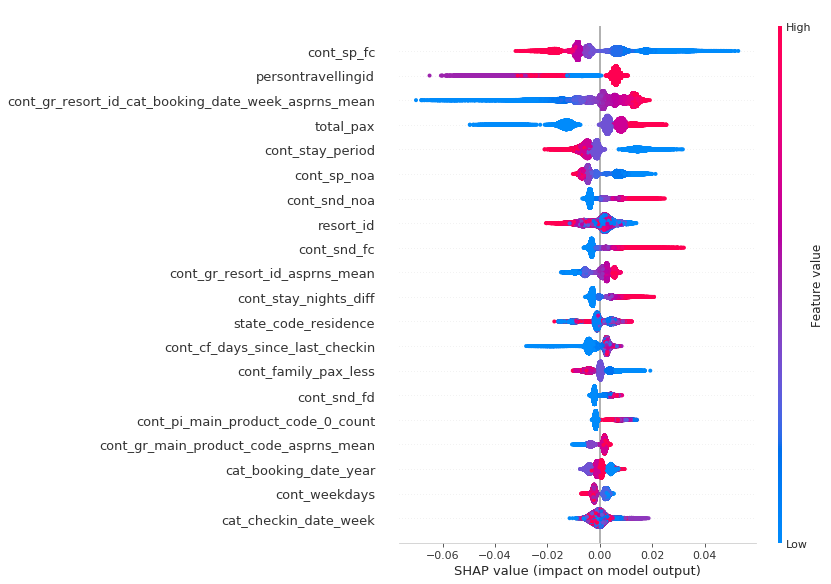

In [104]:
shap.summary_plot(shap_values, pd.DataFrame(X_test, columns=categorical_features + continuous_features))

In [125]:
X_test_df = pd.DataFrame(X_test, columns=categorical_features + continuous_features)

In [115]:
# load JS visualization code to notebook
shap.initjs()

In [126]:
print(y_test[0])
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_df.iloc[0, :])

1.9855730122480555


In [127]:
print(y_test[1])
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test_df.iloc[1, :])

2.1447793609107477


In [131]:
print(y_test[2])
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test_df.iloc[2, :])

2.1953161738254225


In [137]:
y_pred = regressors[0].predict(X_test, regressors[0].best_iteration)

In [142]:
# (reward, penalty)
fet_importance = {ft_name: (0, 0) for ft_name in categorical_features + continuous_features}
for shvp, actual, prediction in zip(shap_values, y_test, y_pred):
    if actual > prediction:
        for ft_val, ft_name in zip(shvp, categorical_features + continuous_features):
            if ft_val > 0:
                fet_importance[ft_name] = (fet_importance[ft_name][0] + abs(ft_val), fet_importance[ft_name][1])
            else:
                fet_importance[ft_name] = (fet_importance[ft_name][0], fet_importance[ft_name][1] + abs(ft_val))
    elif actual < prediction:
        for ft_val, ft_name in zip(shvp, categorical_features + continuous_features):
            if ft_val < 0:
                fet_importance[ft_name] = (fet_importance[ft_name][0] + abs(ft_val), fet_importance[ft_name][1])
            else:
                fet_importance[ft_name] = (fet_importance[ft_name][0], fet_importance[ft_name][1] + abs(ft_val))

In [148]:
f_ratio = []
for k, v in fet_importance.items():
    f_ratio.append((k, v[0] / v[1]))

/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [157]:
ft_shape_drop = [c for c, v in f_ratio if v < 1.0]

In [158]:
joblib.dump(ft_shape_drop, 'data/iterables/ft_shape_drop.joblib')

['data/iterables/ft_shape_drop.joblib']

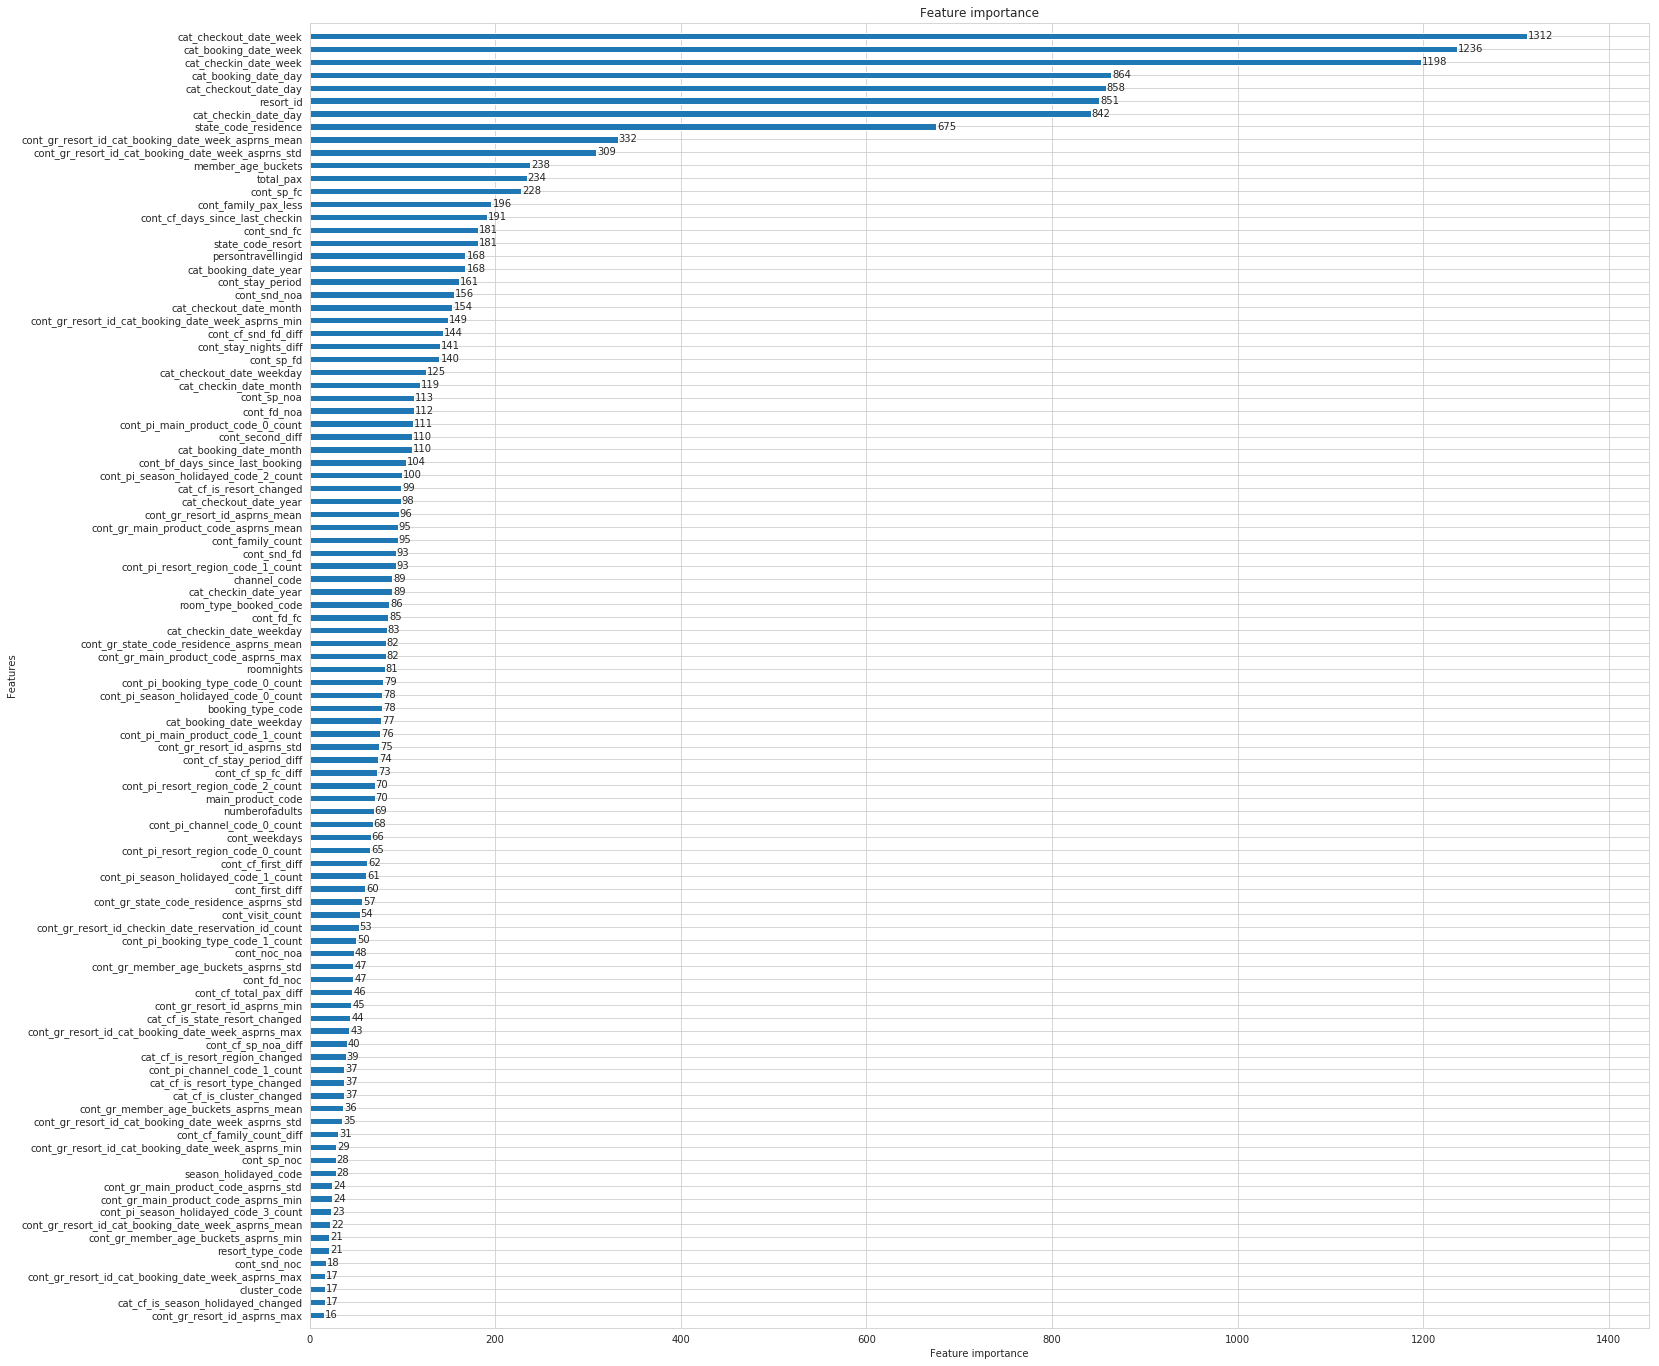

In [99]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(24, 24)
lgb.plot_importance(regressors[0], ax=ax, height=0.5, max_num_features=100);

In [78]:
fnames_0 = list()
for i in range(regressors.__len__()):
    fnames_0.extend([fname for fname, fimp in zip(feature_names, regressors[i].feature_importance()) if fimp == 0])

fnames_0 = list(set(fnames_0))

In [79]:
fnames_1 = list()
for i in range(regressors.__len__()):
    fnames_1.extend([fname for fname, fimp in zip(feature_names, regressors[i].feature_importance()) if fimp != 0])

fnames_1 = list(set(fnames_1))

In [80]:
fnames_0

['cont_gr_state_code_residence_asprns_max',
 'memberid',
 'reservationstatusid_code',
 'cont_pi_main_product_code_4_count',
 'cont_gr_resort_id_cat_booking_date_week_asprns_max',
 'cat_booking_date_is_weekend']

In [40]:
intresting = ['cont_resort_id_asprns',
             'cont_main_product_code_asprns',
             'cont_resort_region_code_asprns',
             'cont_resort_type_code_asprns',
             'cont_member_age_buckets_asprns',
             'cont_state_code_residence_asprns',
             'cont_season_holidayed_code_asprns',
             'cont_cat_booking_date_week_asprns',]
for ci in intresting:
    print(ci, np.sum([1 for c in fnames_1 if ci in c]) / np.sum([1 for c in fnames_0 if ci in c]))

cont_resort_id_asprns 4.0
cont_main_product_code_asprns 4.0
cont_resort_region_code_asprns 0.0
cont_resort_type_code_asprns 1.0
cont_member_age_buckets_asprns 2.0
cont_state_code_residence_asprns 4.0
cont_season_holidayed_code_asprns 1.0
cont_cat_booking_date_week_asprns 1.0


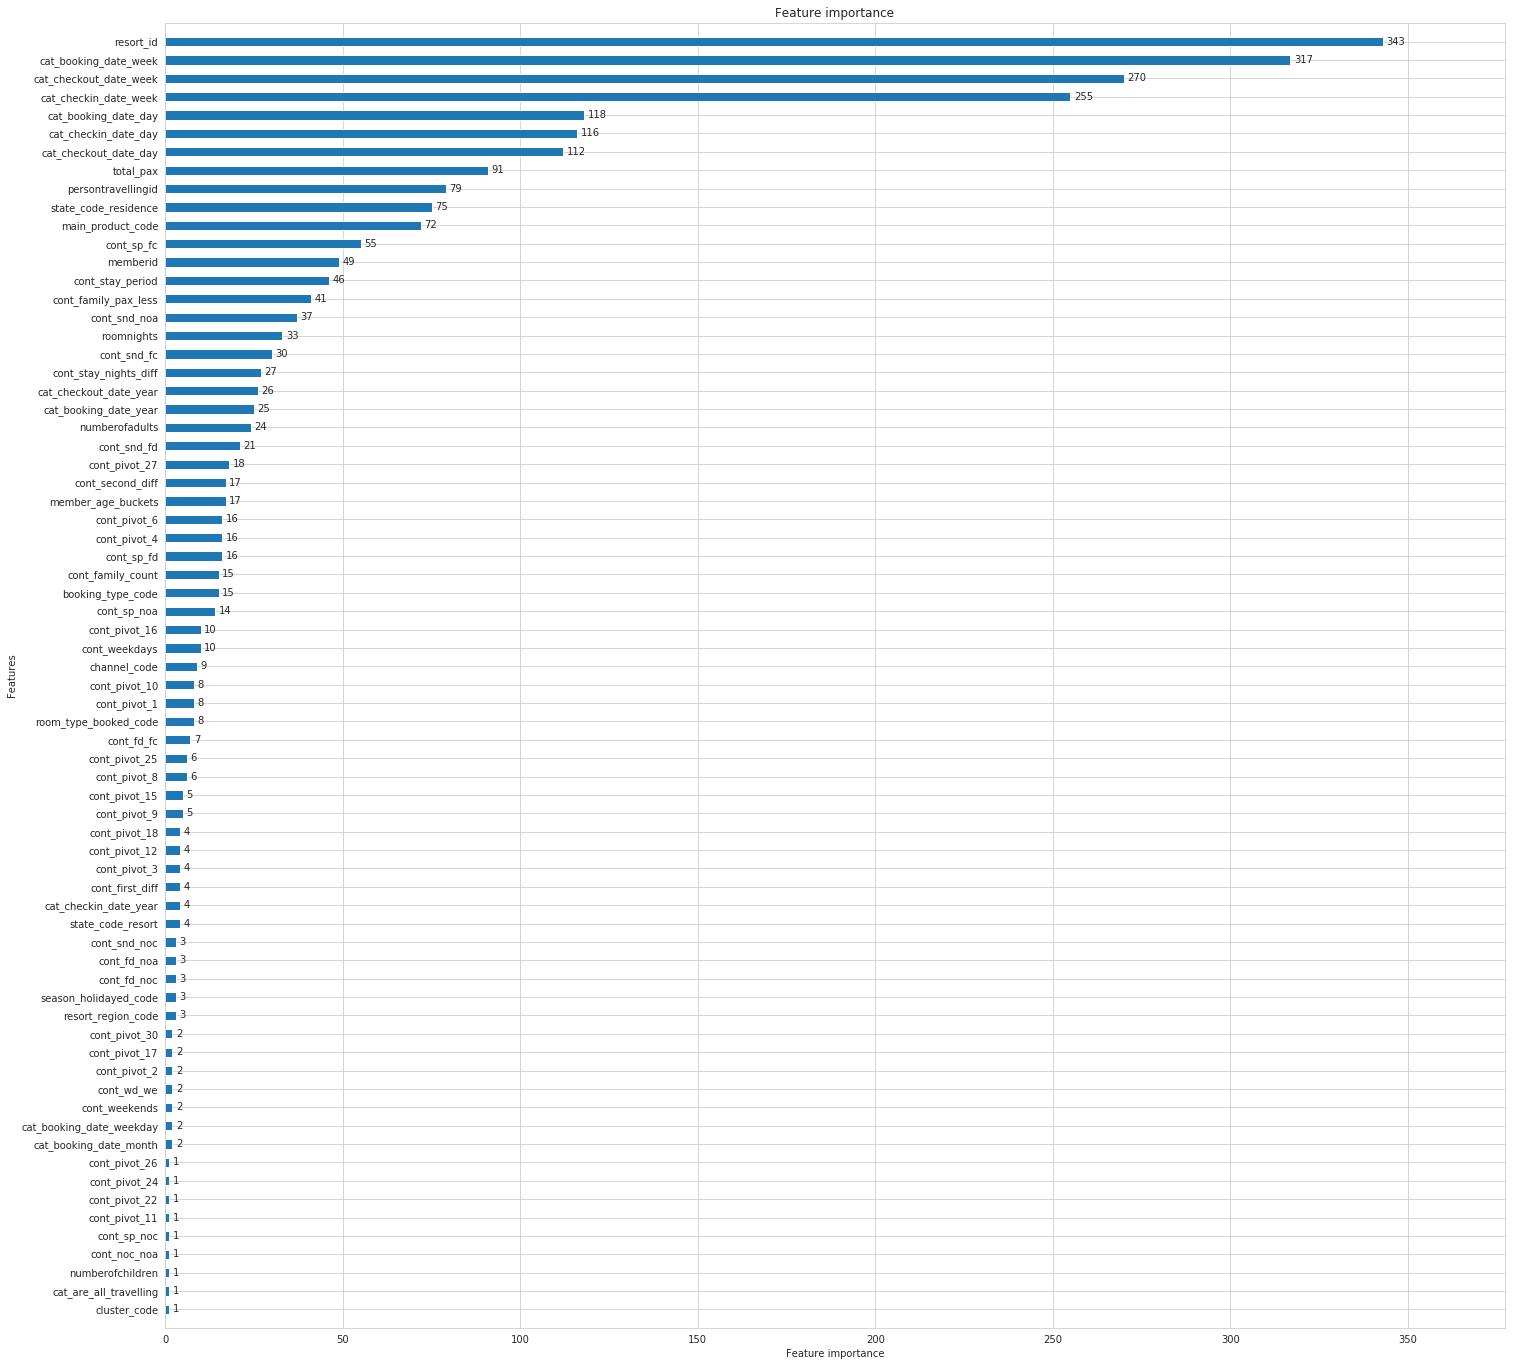

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(24, 24)
lgb.plot_importance(regressors[1], ax=ax, height=0.5, max_num_features=100);

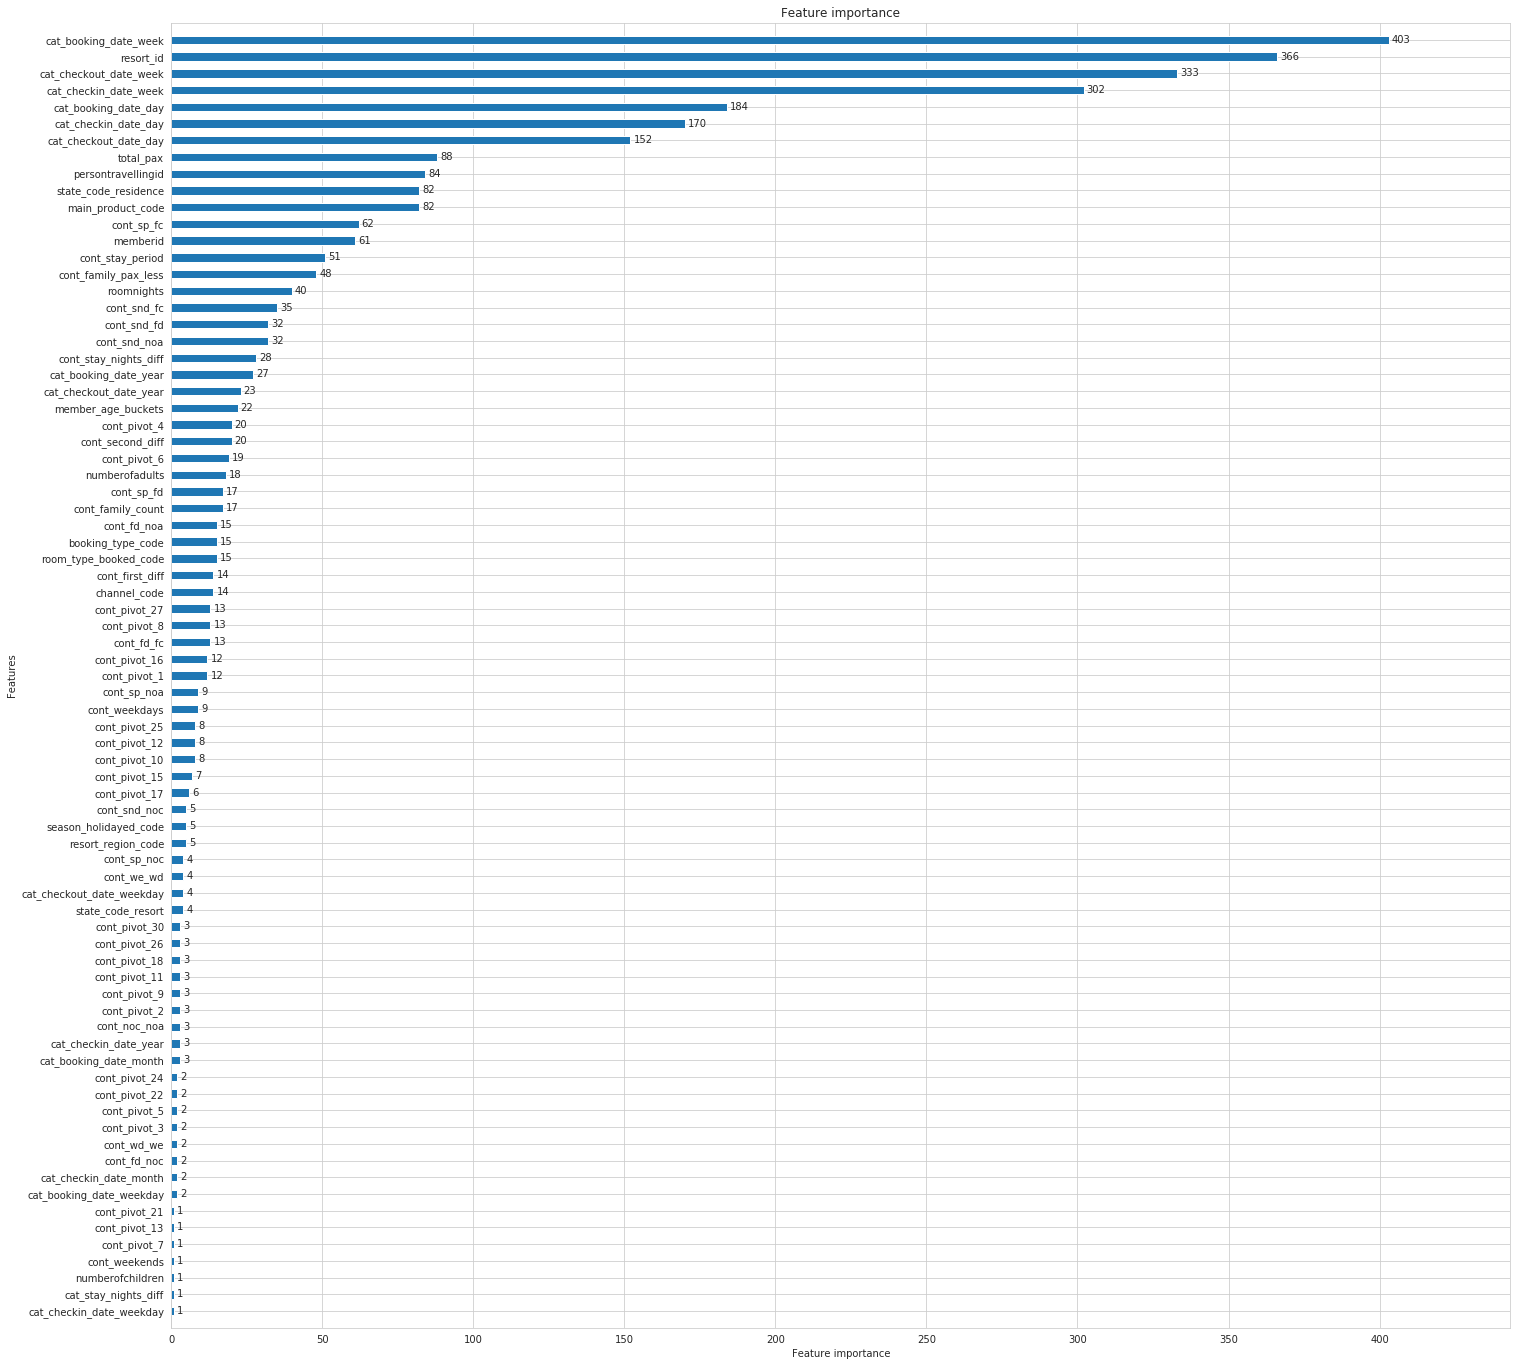

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(24, 24)
lgb.plot_importance(regressors[2], ax=ax, height=0.5, max_num_features=100);